<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Je vais essayer ici d'utiliser un modèle ViT pré-entrainé par Google, mis à disposition sur le site HuggingFace : https://huggingface.co/google/vit-base-patch16-224-in21k

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 5.3 MB/s 
     |████████████████████████████████| 61 kB 389 kB/s 
     |████████████████████████████████| 6.8 MB 15.8 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 


In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
from PIL import Image
import requests
from google.colab import drive
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanAbsoluteError, \
  MeanAbsolutePercentageError
!pip install tensorflow-addons
import tensorflow_addons as tfa
from scipy.io import loadmat

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [3]:
google_vit_model = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(google_vit_model)
model = ViTForImageClassification.from_pretrained(google_vit_model)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

(-0.5, 583.5, 327.5, -0.5)

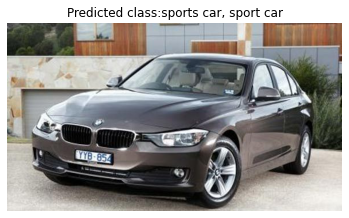

In [4]:
url = 'https://ai.stanford.edu/~jkrause/cars/car1.jpg'
image = Image.open(requests.get(url, stream=True).raw)

def predict(image):
  """
  model predicts one of the 1000 ImageNet classes
  """
  inputs = feature_extractor(images=image, return_tensors="pt")
  outputs = model(**inputs)
  logits = outputs.logits
  predicted_class_idx = logits.argmax(-1).item()
  return model.config.id2label[predicted_class_idx]

plt.title("Predicted class:" + predict(image))
plt.imshow(image)
plt.axis("off")

ça fonctionne ! je vais tester les prédictions avec des images de mon jeu de données "Stanford Cars dataset"

In [5]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


In [6]:
IDX_CLASS_ID = 4
IDX_FILENAME = 5
IMAGES_DIR = 'cars_train'
IMAGES_DIR_TREE = 'cars_train_tree'
cars_meta = loadmat('cars_meta.mat')['class_names'][0]
cars_train_annos = loadmat('cars_train_annos.mat')['annotations'][0]

Je créé une arborescence de liens symboliques pour ranger les images par classe.

In [7]:
import shutil
class_by_filename = {}
if not os.path.exists(IMAGES_DIR_TREE):
    os.makedirs(IMAGES_DIR_TREE)
    for car in cars_train_annos:
        class_id = car[IDX_CLASS_ID][0][0]
        class_name = cars_meta[class_id - 1][0]
        filename = car[IDX_FILENAME][0]
        class_by_filename[filename] = class_name
        class_dir = os.path.join(IMAGES_DIR_TREE, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        src = os.path.join(IMAGES_DIR, filename)
        dst = os.path.join(class_dir, filename)
        if not os.path.exists(dst):
          shutil.copyfile(src, dst)
else:
    for car in cars_train_annos:
        class_id = car[IDX_CLASS_ID][0][0]
        class_name = cars_meta[class_id - 1][0]
        filename = car[IDX_FILENAME][0]
        class_by_filename[filename] = class_name

print(class_by_filename)

{'00001.jpg': 'Audi TTS Coupe 2012', '00002.jpg': 'Acura TL Sedan 2012', '00003.jpg': 'Dodge Dakota Club Cab 2007', '00004.jpg': 'Hyundai Sonata Hybrid Sedan 2012', '00005.jpg': 'Ford F-450 Super Duty Crew Cab 2012', '00006.jpg': 'Geo Metro Convertible 1993', '00007.jpg': 'Dodge Journey SUV 2012', '00008.jpg': 'Dodge Charger Sedan 2012', '00009.jpg': 'Mitsubishi Lancer Sedan 2012', '00010.jpg': 'Chevrolet Traverse SUV 2012', '00011.jpg': 'Buick Verano Sedan 2012', '00012.jpg': 'Toyota Sequoia SUV 2012', '00013.jpg': 'Hyundai Elantra Sedan 2007', '00014.jpg': 'Dodge Caravan Minivan 1997', '00015.jpg': 'Volvo C30 Hatchback 2012', '00016.jpg': 'Plymouth Neon Coupe 1999', '00017.jpg': 'Audi TTS Coupe 2012', '00018.jpg': 'Chevrolet Malibu Sedan 2007', '00019.jpg': 'Volkswagen Beetle Hatchback 2012', '00020.jpg': 'Chevrolet Corvette Ron Fellows Edition Z06 2007', '00021.jpg': 'Chrysler 300 SRT-8 2010', '00022.jpg': 'BMW M6 Convertible 2010', '00023.jpg': 'GMC Yukon Hybrid SUV 2012', '00024.j

In [9]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

     |████████████████████████████████| 526 kB 7.0 MB/s 
     |████████████████████████████████| 332 kB 55.0 MB/s 
     |████████████████████████████████| 376 kB 55.1 MB/s 
     |████████████████████████████████| 829 kB 55.8 MB/s 
     |████████████████████████████████| 132 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 35.7 MB/s 
     |████████████████████████████████| 192 kB 63.2 MB/s 
     |████████████████████████████████| 160 kB 51.4 MB/s 
     |████████████████████████████████| 271 kB 63.3 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


0.75.3


In [10]:
from hugsvision.dataio.VisionDataset import VisionDataset

train, test, id2label, label2id = VisionDataset.fromImageFolder(
	IMAGES_DIR_TREE,
	test_ratio   = 0.2,
	balanced     = True,
	augmentation = True
)

Split Datasets...
Balance train dataset...
The less represented label in train as 24 occurrences
Size of train after balancing is 4704
train_ds:  3763
+---------+----------------------------+---------------------------+---------------------+---------------------+----------------------+----------------------+--------------------------+------------------------------------------+------------------------------------+--------------------------------------+--------------------------------+---------------------+---------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+------------------------+-----------------------+---------------------+--------------------+-------------------------------+-------------------------+-------------------------+-------------------------+-------------------------------+-------------------------------+-------------------+

In [11]:
len(label2id)

196

In [12]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
google_vit_model = 'google/vit-base-patch16-224-in21k'
trainer = VisionClassifierTrainer(
    model_name   = "CarsModel",
    train      	 = train,
    test      	 = test,
    output_dir   = "./out/",
    max_epochs   = 1,
    batch_size   = 32,
    lr 		       = 2e-5,
    fp16	     = True,
    model = ViTForImageClassification.from_pretrained(
        google_vit_model,
        num_labels = len(label2id),
        label2id   = label2id,
        id2label   = id2label
    ),
    feature_extractor = ViTFeatureExtractor.from_pretrained(
        google_vit_model,
    ),
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

{'0': 'AM General Hummer SUV 2000', '1': 'Acura Integra Type R 2001', '2': 'Acura RL Sedan 2012', '3': 'Acura TL Sedan 2012', '4': 'Acura TL Type-S 2008', '5': 'Acura TSX Sedan 2012', '6': 'Acura ZDX Hatchback 2012', '7': 'Aston Martin V8 Vantage Convertible 2012', '8': 'Aston Martin V8 Vantage Coupe 2012', '9': 'Aston Martin Virage Convertible 2012', '10': 'Aston Martin Virage Coupe 2012', '11': 'Audi 100 Sedan 1994', '12': 'Audi 100 Wagon 1994', '13': 'Audi A5 Coupe 2012', '14': 'Audi R8 Coupe 2012', '15': 'Audi RS 4 Convertible 2008', '16': 'Audi S4 Sedan 2007', '17': 'Audi S4 Sedan 2012', '18': 'Audi S5 Convertible 2012', '19': 'Audi S5 Coupe 2012', '20': 'Audi S6 Sedan 2011', '21': 'Audi TT Hatchback 2011', '22': 'Audi TT RS Coupe 2012', '23': 'Audi TTS Coupe 2012', '24': 'Audi V8 Sedan 1994', '25': 'BMW 1 Series Convertible 2012', '26': 'BMW 1 Series Coupe 2012', '27': 'BMW 3 Series Sedan 2012', '28': 'BMW 3 Series Wagon 2012', '29': 'BMW 6 Series Convertible 2007', '30': 'BMW Ac

Using amp half precision backend
***** Running training *****
  Num examples = 3763
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 118


Trainer builded!
Start Training!


Epoch,Training Loss,Validation Loss
1,No log,5.247406


***** Running Evaluation *****
  Num examples = 941
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./out/CARSMODEL/1_2021-12-31-07-42-54/trainer/
Configuration saved in ./out/CARSMODEL/1_2021-12-31-07-42-54/trainer/config.json
Model weights saved in ./out/CARSMODEL/1_2021-12-31-07-42-54/trainer/pytorch_model.bin
Configuration saved in ./out/CARSMODEL/1_2021-12-31-07-42-54/model/config.json
Model weights saved in ./out/CARSMODEL/1_2021-12-31-07-42-54/model/pytorch_model.bin
Configuration saved in ./out/CARSMODEL/1_2021-12-31-07-42-54/feature_extractor/preprocessor_config.json


Model saved at: ./out/CARSMODEL/1_2021-12-31-07-42-54


In [13]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 941/941 [00:30<00:00, 30.47it/s]

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000     0.0000    0.0000    0.0000         4
                             Acura Integra Type R 2001     0.0000    0.0000    0.0000         5
                                   Acura RL Sedan 2012     0.0000    0.0000    0.0000         6
                                   Acura TL Sedan 2012     0.0312    0.2500    0.0556         4
                                  Acura TL Type-S 2008     0.0000    0.0000    0.0000         7
                                  Acura TSX Sedan 2012     0.0000    0.0000    0.0000         6
                              Acura ZDX Hatchback 2012     0.0000    0.0000    0.0000         5
              Aston Martin V8 Vantage Convertible 2012     0.0000    0.0000    0.0000         4
                    Aston Martin V8 Vantage Coupe 2012     0.0000    0.0000    0.0000         3
                  Aston Martin Virage C

Ici je copie le fichier config.json en preprocessor_config.json dans le répertoire du modèle ("path" ci-dessous)

loading feature extractor configuration file ./out/CARSMODEL/1_2021-12-31-07-42-54/model/preprocessor_config.json
Feature extractor ViTFeatureExtractor {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "_processor_class": null,
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AM General Hummer SUV 2000",
    "1": "Acura Integra Type R 2001",
    "10": "Aston Martin Virage Coupe 2012",
    "100": "Ferrari 458 Italia Convertible 2012",
    "101": "Ferrari 458 Italia Coupe 2012",
    "102": "Ferrari California Convertible 2012",
    "103": "Ferrari FF Coupe 2012",
    "104": "Fisker Karma Sedan 2012",
    "105": "Ford E-Series Wagon Van 2012",
    "106": "Ford Edge SUV 2012",
    "107": "Ford Expedition EL SUV 2009",
    "108": "Ford F-1

Model loaded!
Predicted class: Buick Enclave SUV 2012


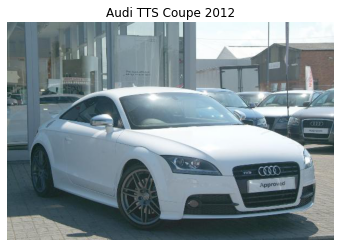

In [15]:
from hugsvision.inference.VisionClassifierInference import VisionClassifierInference
from shutil import copyfile

path = "./out/CARSMODEL/1_2021-12-31-07-42-54/model/"
src = os.path.join(path, 'config.json')
dst = os.path.join(path, 'preprocessor_config.json')
copyfile(src, dst)

class_name = 'Audi TTS Coupe 2012'
class_dir = os.path.join(IMAGES_DIR_TREE, class_name)
image_name = os.listdir(class_dir)[0]
image_path = os.path.join(class_dir, image_name)
image = Image.open(image_path)
plt.title(class_name)
plt.imshow(image)
plt.axis("off")

classifier = VisionClassifierInference(
    feature_extractor = ViTFeatureExtractor.from_pretrained(path),
    model = ViTForImageClassification.from_pretrained(path),
)

label = classifier.predict(img_path=image_path)
print("Predicted class:", label)

ça fonctionne ! Je teste sur plusieurs images :

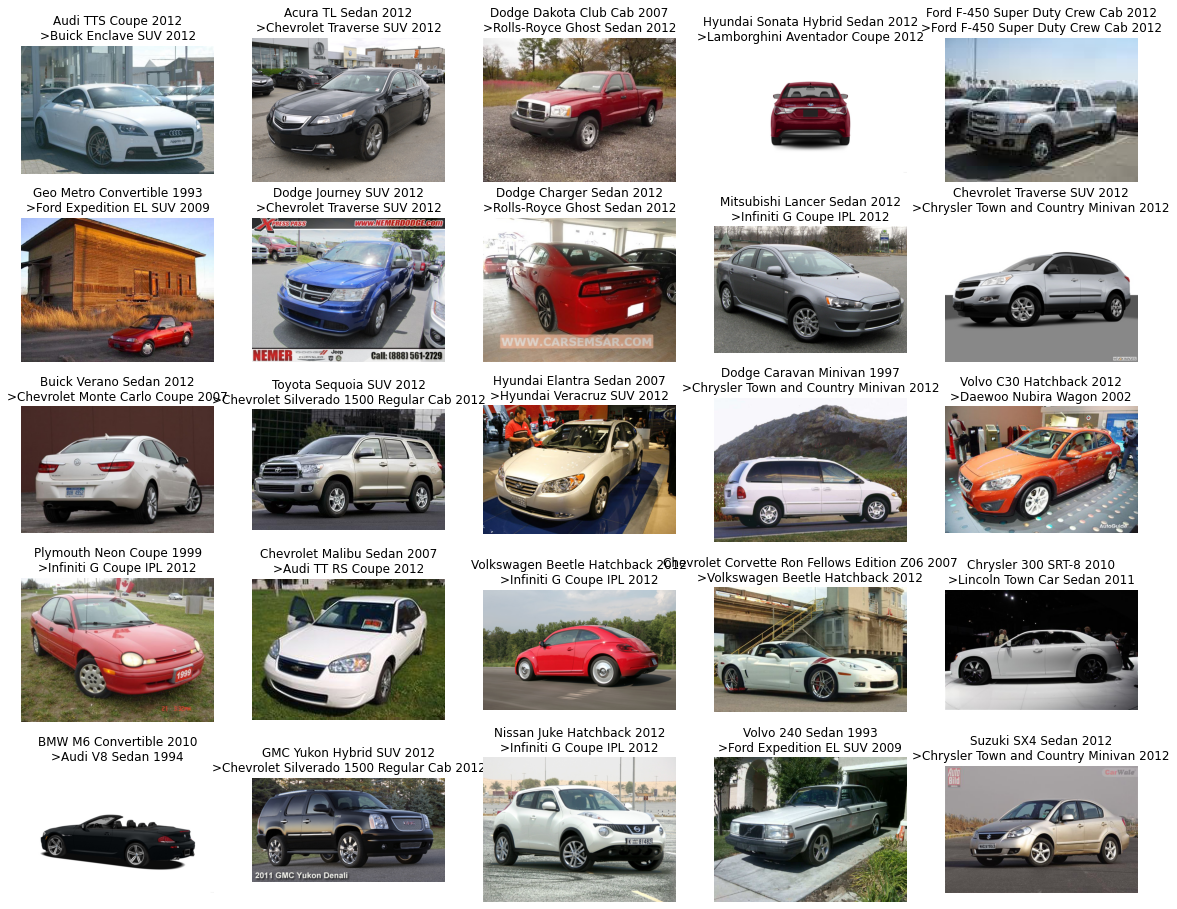

In [21]:
plt.figure(figsize=(20, 16))
i = 1
for sub_dir in os.listdir(IMAGES_DIR_TREE)[:25]:
    sub_dir_images = os.listdir(os.path.join(IMAGES_DIR_TREE, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            img_path = os.path.join(IMAGES_DIR_TREE, sub_dir, sub_dir_image)
            img = Image.open(img_path)
            plt.subplot(5, 5, i)
            plt.axis('off')
            prediction = classifier.predict(img_path=img_path)
            plt.title(sub_dir + '\n>' + prediction)
            plt.imshow(img)
            i = i + 1
            j = j + 1
plt.show()

Il donne la bonne réponse 1 fois sur 25... c'est plutôt mauvais !